In [1]:
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
import pandas as pd
import sys
import old_references.nonlinear_QM_FPJPA as Fs
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import standard_sequences.rabi as rabi
import standard_sequences.rabi_ef_swap as rabi_ef_swap
import standard_sequences.rabi_ef_no_swap as rabi_ef_no_swap
import classifiers.classifier as classifier
import analysis.analysis as analysis
import seaborn as sns
from scipy.optimize import curve_fit
import time
import traceback

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)
bnc.set_bnc_output(
    general_vals_dict["TWPA_freq"],
    general_vals_dict["TWPA_pwr"],
    bnc_addr=bnc_address["big_agilent"],
)
general_vals_dict["wx_offs"] = [0.7, 0, -0.08, 0]  # offset to sweet spot

Qubit(ROIF=0.10268999999999995, RO_LO_pwr=16, qubit_thr=[-10000, -600], ro_dur=5000, ro_amp=0.15, RO_IF=None, ef_amp=1.48, ro_freq=6.72739, ge_time=82, qubit_id=q1, IQ_angle=110, ef_time=49, RO_LO=6.6247, ef_ssm=-0.2568, ge_ssm=-0.1144, ge_amp=0.795)
Qubit(ROIF=0.030840000000000423, RO_LO_pwr=16, qubit_thr=[-10000, 1900], ro_dur=5000, ro_amp=0.7, RO_IF=None, ef_amp=1, ro_freq=6.65554, ge_time=55, qubit_id=q2, IQ_angle=25, ef_time=None, RO_LO=6.6247, ef_ssm=-0.2962, ge_ssm=-0.154, ge_amp=0.8)


In [3]:
a_to_J = ((2 * np.pi) / (2 * (2 * q1.ef_time * 10**-3))) / q1.ef_amp
        # if J is in units of rad/micros
J_to_a = 1 / a_to_J

In [4]:
def run_rabi_ef_swap(
    q1: object,
    q2: object,
    general_vals_dict: dict,
    num_steps: int,
    sweep_time: float,
    swap_freq: float,
    swap_time: float,
    reps: int,
):
    """
    Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi_ef_swap.rabi_ef_swap(
        q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq, swap_time
    )
    # rabi_ef_swap.rabi_ef_swap_f(
    #     q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq, swap_time
    # )
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})

    # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    classified = classifier.classify(IQ_df)
    states = classified["predicted"]
    # Reshape the predicted states.
    # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    #  where each row corresponds to a time step and holds all the state measurements for that step.)
    states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    probabilties = classifier.probabilities(states_reshaped)
    population = classifier.population(states_reshaped)

    # Compute time values as the index for the DataFrame.
    times = np.linspace(0, sweep_time / 1000, num_steps)

    # Build a DataFrame that holds the probability vs. time.
    df_prob = pd.DataFrame(
        {
            "time": times,
            "P_f": probabilties["P_f"],
            "P_e": probabilties["P_e"],
            "P_g": probabilties["P_g"],
        },
        index=times,
    )

    df_pop = pd.DataFrame(
        {
            "time": times,
            "Pop_f": population["Pop_f"],
            "Pop_e": population["Pop_e"],
            "Pop_g": population["Pop_g"],
        },
        index=times,
    )

    return df_prob, df_pop, values


def sweep_J(J_list: list):
    """
    Sweeps the frequency for the ef transition.
    For each frequency, it runs the experiment (via run_rabi_ef_swap) which returns a
    probability-vs-time DataFrame. Then it compiles these results into a dictionary
    where the keys are the frequency values (floats) and the values are the corresponding
    DataFrames.

    Returns:
        probability_dataframes (dict): A dictionary mapping frequency values to DataFrames.
            Each DataFrame has rows corresponding to time values (computed as
            np.linspace(0, sweep_time/1000, num_steps)) and columns for the state probabilities.
    """
    # Ensure the output directories exist

    probs_folder = os.path.join("sweep_J_data", "probs")
    values_folder = os.path.join("sweep_J_data", "values")
    os.makedirs(probs_folder, exist_ok=True)
    os.makedirs(values_folder, exist_ok=True)
    num_steps = 51
    reps = 12000
    sweep_time = 70000
    swap_freq = -0.0194
    swap_time = 0.5 * 7 / abs(swap_freq)

    # Create an array of frequency values
    J_vals = J_list

    # Initialize the dictionary with frequency keys set to None (or an empty placeholder)
    return_dict = {}
    return_vals = {}

    
    # Loop over frequencies and populate the dictionary
    for J in J_vals:
        prob_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")
        values_filename = os.path.join(values_folder, f"j={J:.3f}.pkl")

        # If both files already exist, load them and skip this iteration
        if os.path.exists(prob_filename) and os.path.exists(values_filename):
            with open(prob_filename, "rb") as f:
                df_prob = pickle.load(f)
            with open(values_filename, "rb") as f:
                values = pickle.load(f)
            return_dict[J] = df_prob
            return_vals[J] = values
            continue  # Skip to the next J value
        ef_amp = J * J_to_a
        q1.ef_amp = ef_amp
        df_prob, df_pop, values = run_rabi_ef_swap(
            q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq, swap_time, reps
        )
        # Populate the dictionary at the corresponding frequency key
        return_dict[J] = df_prob
        return_vals[J] = values

        # Create filenames with the current J value
        prob_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")
        values_filename = os.path.join(values_folder, f"j={J:.3f}.pkl")

        # Save df_prob to a pickle file
        with open(prob_filename, "wb") as f:
            pickle.dump(df_prob, f)
            del df_prob
        # Save values to a pickle file
        with open(values_filename, "wb") as f:
            pickle.dump(values, f)
            del values
    return return_dict, return_vals

In [5]:
def fit_func(J, J0):
    """
    Model function: Re(sqrt(2*(J^2 - J0^2))).
    Returns sqrt(2*(J^2 - J0^2)) if the argument is non-negative;
    otherwise returns 0.

    Parameters:
        J : array_like
            The independent variable.
        J0 : float
            The parameter to fit.

    Returns:
        array_like : The computed model values.
    """
    expr = 2 * (J**2 - J0**2)
    return np.where(expr >= 0, np.sqrt(expr), 0.0)


def curve_fit_function(J_data, y_data, initial_guess_J0=1.0):
    """
    Fits the data (J_data, y_data) to the function
         f(J) = Re(sqrt(2*(J^2 - J0^2)))
    using the provided initial guess for J0.

    Parameters:
        J_data : array_like
            The independent variable data.
        y_data : array_like
            The dependent variable data.
        initial_guess_J0 : float, optional
            Initial guess for the parameter J0 (default is 1.0).

    Returns:
        popt : ndarray
            Optimal value for J0.
        pcov : 2D ndarray
            The estimated covariance of popt.
    """
    popt, pcov = curve_fit(fit_func, J_data, y_data, p0=[initial_guess_J0])
    return popt, pcov


def curve_fit_and_plot(J_data, y_data, initial_guess_J0=1.0):
    """
    Fits the given data to the model function (without offset) and plots the original data
    (scatter plot) along with the fitted curve.

    Parameters:
        J_data : array_like
            The independent variable data.
        y_data : array_like
            The dependent variable data.
        initial_guess_J0 : float, optional
            Initial guess for the parameter J0 (default is 1.0).

    Returns:
        popt : ndarray
            The optimal parameter (J0) from the curve fitting.
        pcov : 2D ndarray
            The covariance matrix of the fitted parameter.
    """
    # Perform the curve fit
    popt, pcov = curve_fit_function(J_data, y_data, initial_guess_J0)
    fitted_J0 = popt[0]
    print("Fitted J0 =", fitted_J0)

    # Generate a smooth set of points for plotting the fitted curve
    J_fit = np.linspace(np.min(J_data), np.max(J_data), 1000)
    y_fit = fit_func(J_fit, fitted_J0)

    # Create the plot: scatter for original data and line for fitted curve
    plt.figure(figsize=(8, 5))
    plt.scatter(J_data, y_data, label="Original Data", color="blue", s=30)
    plt.plot(J_fit, y_fit, label="Fitted Curve", color="red", linewidth=2)
    plt.xlabel("J")
    plt.ylabel("Re(sqrt(2*(J^2 - J0^2)))")
    plt.title("Curve Fit: Data and Fitted Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

    return popt, pcov

In [6]:
# def run_rabi_ef_no_swap(
#     q1: object,
#     q2: object,
#     general_vals_dict: dict,
#     ef_amp: float,
#     num_steps: int,
#     sweep_time: float,
#     reps: int,
# ):
#     """
#     Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
#     and processes the resulting IQ data to compute probabilities vs. time.

#     Returns:
#         df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
#                                 np.linspace(0, sweep_time/1000, num_steps)) and which has
#                                 columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
#                                 of the f, e, and g states respectively.
#     """
#     # Run the experiment
#     rabi_ef_no_swap.rabi_ef_no_swap(
#         q1,
#         q2,
#         general_vals_dict,
#         ef_amp,
#         num_steps,
#         sweep_time,
#     )
#     wx.wx_set_and_amplitude_and_offset(
#         amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
#     )
#     # Acquire the raw IQ data
#     values = daq.run_daq_het_2q(
#         q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
#     )

#     return values


# def run_swap(
#     q1: object,
#     q2: object,
#     general_vals_dict: dict,
#     swap_freq: float,
#     num_steps: int,
#     sweep_time: float,
#     reps: int,
# ):
#     """
#     Runs a single instance of the nonhermitian ef Rabi experiment (with an e-swap to Q2)
#     and processes the resulting IQ data to compute probabilities vs. time.

#     Returns:
#         df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
#                                 np.linspace(0, sweep_time/1000, num_steps)) and which has
#                                 columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
#                                 of the f, e, and g states respectively.
#     """
#     # Run the experiment
#     rabi_ef_swap.swap(q1, q2, general_vals_dict, num_steps, sweep_time, swap_freq)
#     wx.wx_set_and_amplitude_and_offset(
#         amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
#     )
#     # Acquire the raw IQ data
#     values = daq.run_daq_het_2q(
#         q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
#     )

#     return values

In [ ]:
J_start = 0
J_stop = 1.5
J_steps = 151
# J_list = np.linspace(10, 10,1)#
J_list = np.linspace(J_start, J_stop, J_steps)
# Main loop: if an error occurs, print it, wait, and restart
while True:
    try:
        #rx, ry = run_amp_measurements()
        J_dict, vals_dict = sweep_J(J_list)
        break  # Exit loop when measurements complete successfully
    except Exception as e:
        print("An error occurred:")
        traceback.print_exc()
        print("Restarting in 5 seconds...")
        time.sleep(5)


writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.204
0, No error
10.225.208.204
0, No error
0, No error
10.225.208.204
0, No error
10.225.208.204
0, No error
Patterns: 51
Records per pattern: 12000
Buffers per acquistion: 200
DAQ samples per pattern: 8192
0, No error
Capturing 200 buffers. Press <enter> to abort
Capture completed in 62.684176 sec
Captured 200 buffers (3.190598 buffers per sec)
Captured 614400 records (9801.516664 records per sec)
Transferred 10066329600 bytes (160588049.024321 bytes per sec)
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 51
loading ch1
load

In [ ]:
def sweep_J_curve_fit(probability_dataframes):
    """
    Loops over each J in the probability_dataframes dictionary, performs a
    renormalization and curve fit on the P_f data, and returns a dictionary
    mapping J values to the extracted Rabi angular frequency.

    Parameters:
        probability_dataframes (dict): Dictionary with keys as J values and values as
                                       DataFrames containing columns 'time', 'P_f', 'P_e', etc.
        guess_gamma (float): Initial guess for gamma used in the curve fit for J <= 0.25.
        guess_freq (float): Initial guess for frequency used in the curve fit for J > 0.25.

    Returns:
        omega_values (dict): Dictionary mapping each J value to its extracted angular frequency
                             in rad/µs.
    """
    omega_values = {}

    for J, df in probability_dataframes.items():
        # Extract the time and state probability data from the DataFrame
        times = df["time"].values
        P_f = df["P_f"].values
        P_e = df["P_e"].values
        # print(J)
        # Renormalize: P_f_norm = P_f / (P_f + P_e)
        norm_factor = P_f + P_e
        # Avoid division by zero (if that case can ever occur)
        norm_factor[norm_factor == 0] = 1

        guess_gamma = np.sqrt(abs(0.2**2 - J**2))
        guess_freq = np.sqrt(abs(0.2**2 - J**2)) / np.pi
        # Select initial guess values based on J
        if J <= 0.2:
            P_f_norm = P_f# /  norm_factor
            # P_f_norm = P_f
            guess_vals = [0.0001, guess_gamma, 1.6, -30, 0.85]
        else:
            P_f_norm = P_f 
            guess_vals = [guess_freq, 0, 0.1, -10, 0.03]
        guess_vals = [guess_freq, 0, 0.1, -10, 0.03]
        # guess_vals = [0, guess_gamma, 0.1, -10, 0.03]
        # Perform the curve fit using analysis.fit_sine_decay.
        # It is assumed that this function returns a tuple where the first element
        # is an array of fit parameters, with the first parameter corresponding to frequency.
        fit_vals_f, _, _, _ = analysis.fit_sine_decay(
            times, P_f_norm, guess_vals=guess_vals
        )

        # Calculate the angular frequency: omega = |(freq * 2π)|
        omega_rabi_f = abs(fit_vals_f[0] * 2 * np.pi)

        print(f"J = {J}: Angular freq (rad/µs): {omega_rabi_f}")
        omega_values[J] = omega_rabi_f

    return omega_values

RuntimeError


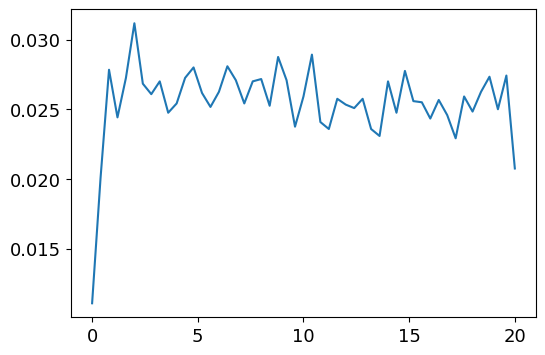



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.0: Angular freq (rad/µs): nan
RuntimeError


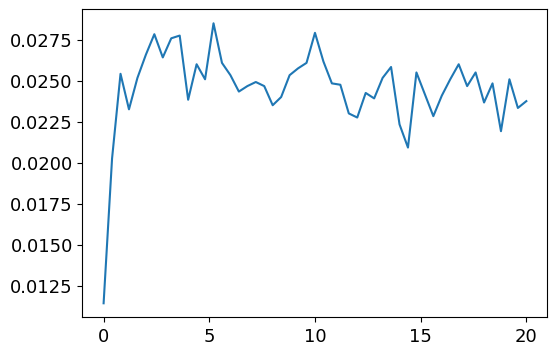



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.01: Angular freq (rad/µs): nan
RuntimeError


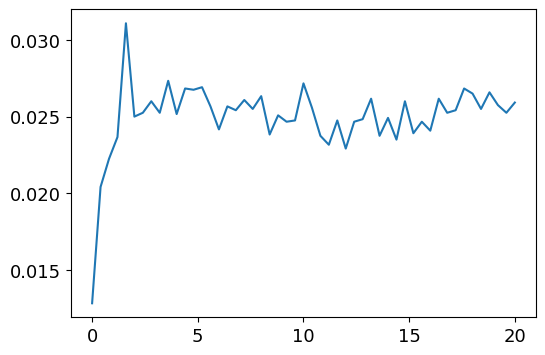



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.02: Angular freq (rad/µs): nan
RuntimeError


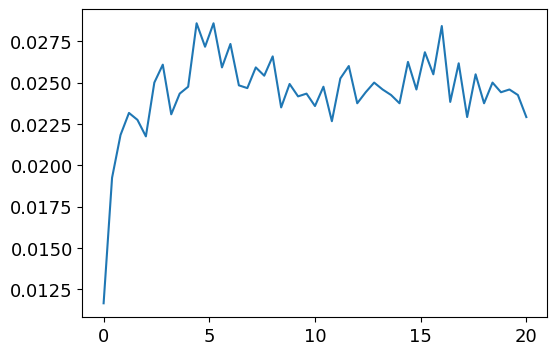



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.03: Angular freq (rad/µs): nan
RuntimeError


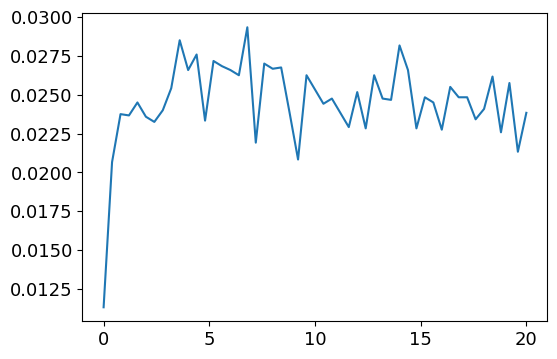



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.04: Angular freq (rad/µs): nan


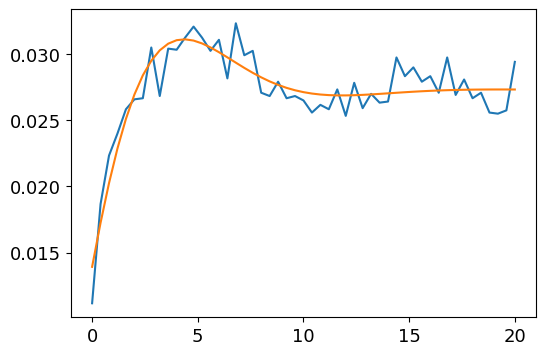



  freq: 0.06690072705978864 +/- 0.010378747158998688
 gamma: 0.30020880124124777 +/- 0.040557868886781555
   amp: 0.017384447826092116 +/- 0.0032213722631035746
 phase: -50.242403545318766 +/- 10.135065666770343
offset: 0.027286076501543372 +/- 0.0002695048973390953
pi_pulse time: 7.473760330783162 +/- 0.010378747158998688
J = 0.05: Angular freq (rad/µs): 0.42034966530169576
RuntimeError


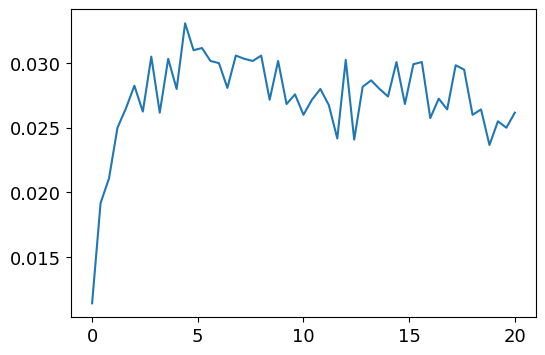



  freq: nan +/- nan
 gamma: nan +/- nan
   amp: nan +/- nan
 phase: nan +/- nan
offset: nan +/- nan
pi_pulse time: nan +/- nan
J = 0.06: Angular freq (rad/µs): nan


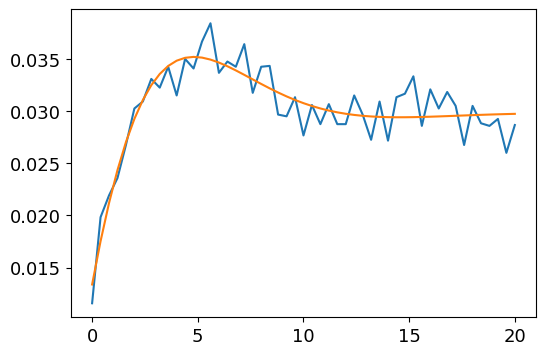



  freq: 0.05134285642739651 +/- 0.010091507893785021
 gamma: 0.2715463279778349 +/- 0.03663575991801205
   amp: 0.026074486834744306 +/- 0.00644707122948981
 phase: -39.00275535318414 +/- 10.184621112107974
offset: 0.02979245406962163 +/- 0.00043744327075794415
pi_pulse time: 9.738453112889145 +/- 0.010091507893785021
J = 0.07: Angular freq (rad/µs): 0.32259668113324874


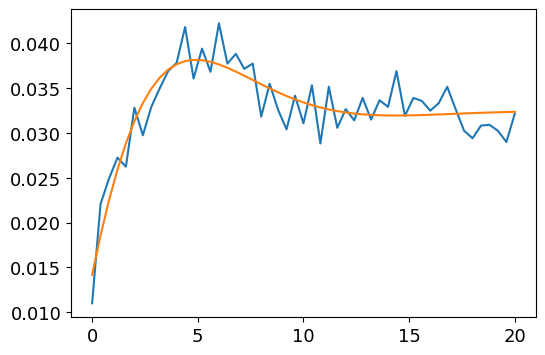



  freq: 0.05282656060655355 +/- 0.011227428722423381
 gamma: 0.26680736321735127 +/- 0.040834047196619566
   amp: 0.027289903419805344 +/- 0.007209688395261403
 phase: -41.95315254578887 +/- 11.844960585805486
offset: 0.03241636237280884 +/- 0.0005328673301585054
pi_pulse time: 9.46493571148698 +/- 0.011227428722423381
J = 0.08: Angular freq (rad/µs): 0.3319190694319292


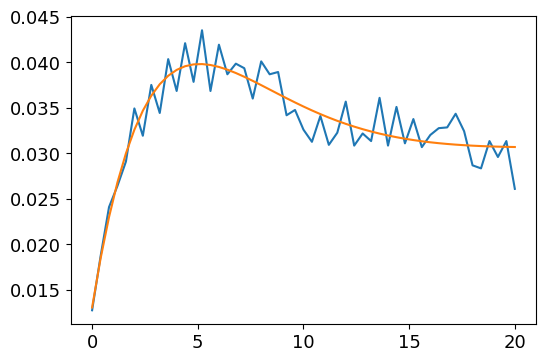



  freq: 0.029706983067296584 +/- 0.014959767168359164
 gamma: 0.2559381332842738 +/- 0.03483237456606676
   amp: 0.05633833913129059 +/- 0.03390875394380836
 phase: -18.32161088667514 +/- 11.790331628884296
offset: 0.030769881832254684 +/- 0.0012615804454434807
pi_pulse time: 16.83105951443562 +/- 0.014959767168359164
J = 0.09: Angular freq (rad/µs): 0.18665447952907066


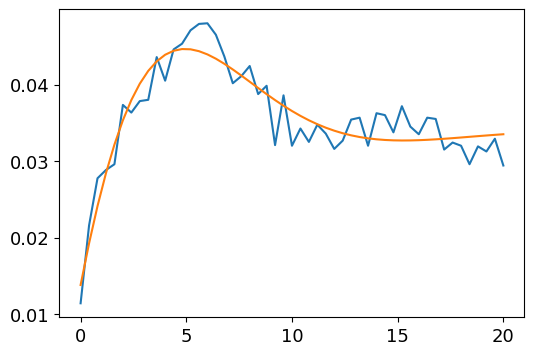



  freq: 0.04843259736916464 +/- 0.006141208151477987
 gamma: 0.21548227928081892 +/- 0.0288007402124593
   amp: 0.03837615726992767 +/- 0.007874025111065415
 phase: -31.487373277330025 +/- 6.475554724521996
offset: 0.033852518095592914 +/- 0.000688662981560085
pi_pulse time: 10.323625557161069 +/- 0.006141208151477987
J = 0.1: Angular freq (rad/µs): 0.3043109841784799


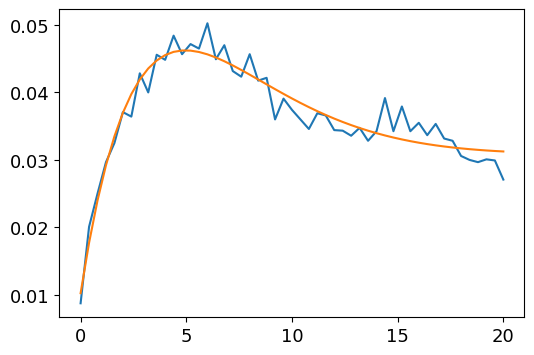



  freq: 0.023537125877889187 +/- 0.013216466245246503
 gamma: 0.25085638484153 +/- 0.026755805848807757
   amp: 0.10410767539130487 +/- 0.06815292074325285
 phase: -11.495726500422238 +/- 8.124074364034803
offset: 0.030992486816372265 +/- 0.0017947693220265021
pi_pulse time: 21.243035474849577 +/- 0.013216466245246503
J = 0.11: Angular freq (rad/µs): 0.14788812348918975


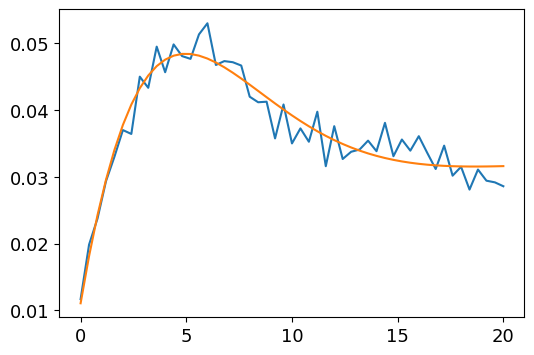



  freq: 0.03663778834699926 +/- 0.006686200459278931
 gamma: 0.2175360495640099 +/- 0.024460991845670025
   amp: 0.06532615654772915 +/- 0.017336360014974333
 phase: -19.041360351471354 +/- 5.476080624007663
offset: 0.03236099811394068 +/- 0.00122497702557037
pi_pulse time: 13.647111972602229 +/- 0.006686200459278931
J = 0.12: Angular freq (rad/µs): 0.2302020134294212


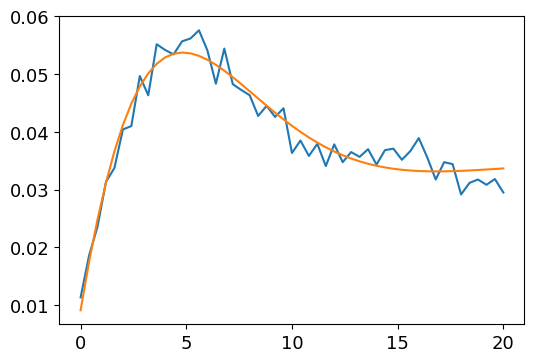



  freq: 0.0416521770841312 +/- 0.004620183104698184
 gamma: 0.21349551459080796 +/- 0.020609878724586504
   amp: 0.0691548166221608 +/- 0.012310364822560243
 phase: -21.64990120875428 +/- 4.019157339586144
offset: 0.034625824988018486 +/- 0.0009740215082069193
pi_pulse time: 12.00417445143562 +/- 0.004620183104698184
J = 0.13: Angular freq (rad/µs): 0.2617083470670554


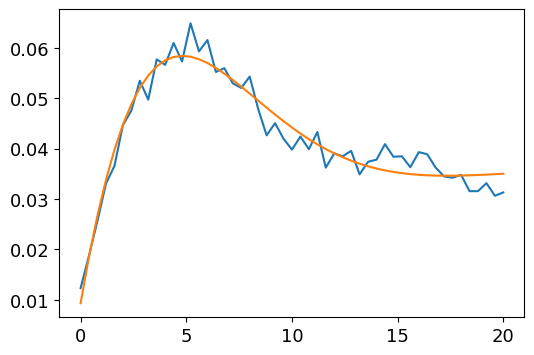



  freq: 0.03992496699518715 +/- 0.004696398991060252
 gamma: 0.21209622826587662 +/- 0.02049194235054616
   amp: 0.08084837280671711 +/- 0.015147621970786354
 phase: -19.423205157206343 +/- 3.863118434833831
offset: 0.03620711908211988 +/- 0.0011792284383059265
pi_pulse time: 12.52349188066389 +/- 0.004696398991060252
J = 0.14: Angular freq (rad/µs): 0.2508559660137898


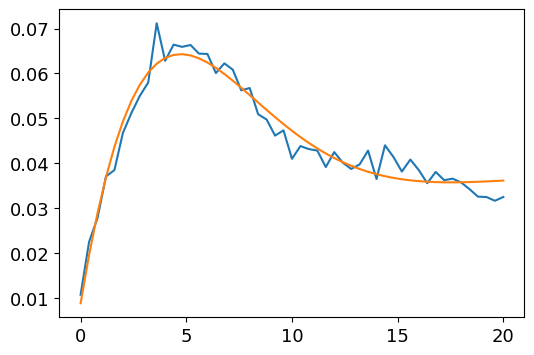



  freq: 0.039095780351016254 +/- 0.00441341879939762
 gamma: 0.21140677343341777 +/- 0.01959250173977984
   amp: 0.09603972174911382 +/- 0.017446020353919848
 phase: -17.389149642378595 +/- 3.396920679693332
offset: 0.037553097312436674 +/- 0.0013404721208430611
pi_pulse time: 12.789103977739199 +/- 0.00441341879939762
J = 0.15: Angular freq (rad/µs): 0.2456460326742257


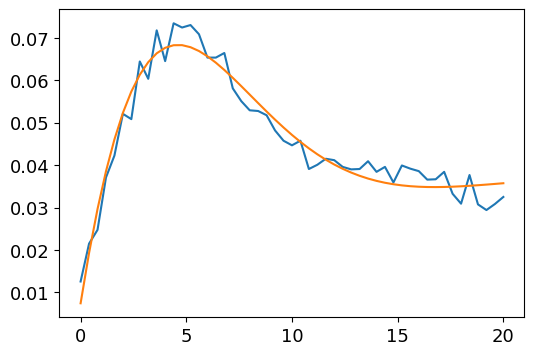



  freq: 0.041236133601178386 +/- 0.003896830956323919
 gamma: 0.20631559143439793 +/- 0.019699889324066043
   amp: 0.10245858694928607 +/- 0.016885518112524027
 phase: -16.97345487753775 +/- 2.982430427615423
offset: 0.03736420037472075 +/- 0.0013820287397398104
pi_pulse time: 12.125288098923798 +/- 0.003896830956323919
J = 0.16: Angular freq (rad/µs): 0.2590942687678185


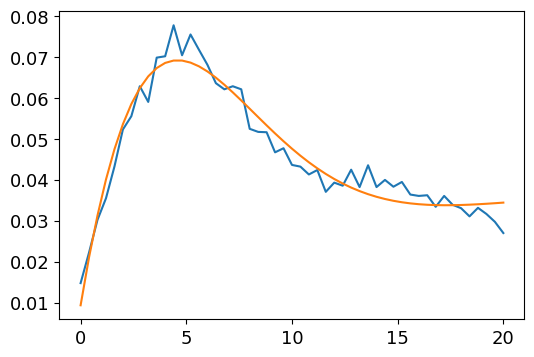



  freq: 0.03940106905804835 +/- 0.0041256580643265805
 gamma: 0.20260552543998908 +/- 0.020545896211965262
   amp: 0.10800533029678398 +/- 0.019645284220841535
 phase: -14.474268723791605 +/- 2.9240139035017543
offset: 0.03632368419441593 +/- 0.0016228714327516799
pi_pulse time: 12.690011006131988 +/- 0.0041256580643265805
J = 0.17: Angular freq (rad/µs): 0.2475642181926976


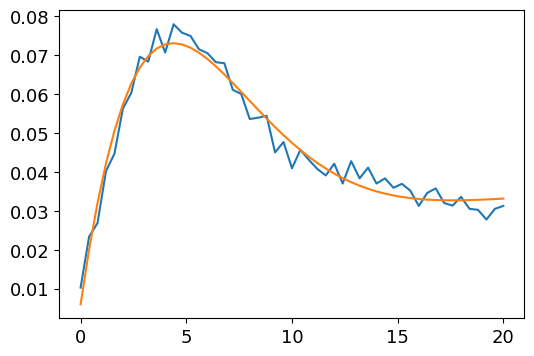



  freq: 0.03790404598642348 +/- 0.0035780479461493047
 gamma: 0.21813724411365595 +/- 0.017147386632208467
   amp: 0.13498252078788897 +/- 0.02101403278202447
 phase: -12.341964128751227 +/- 2.144567944269374
offset: 0.034831859128621946 +/- 0.0014579230838613977
pi_pulse time: 13.191203920000799 +/- 0.0035780479461493047
J = 0.18: Angular freq (rad/µs): 0.23815814482455538


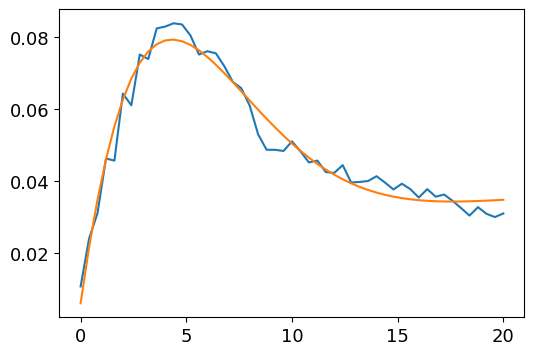



  freq: 0.03771543637843671 +/- 0.0037786853391724965
 gamma: 0.22043613871455697 +/- 0.018240130877840537
   amp: 0.1510672230480982 +/- 0.02494378783055831
 phase: -11.651698853139678 +/- 2.1602135827142668
offset: 0.03660616396786282 +/- 0.001682402913967691
pi_pulse time: 13.257171280825169 +/- 0.0037786853391724965
J = 0.19: Angular freq (rad/µs): 0.23697307570686


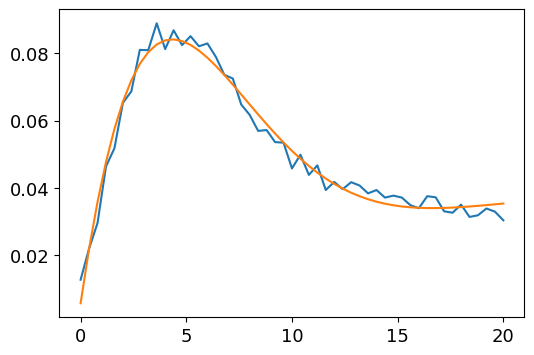



  freq: -0.040688689476447895 +/- 0.0024101994934271793
 gamma: 0.20693355340408998 +/- 0.013407275861918802
   amp: -0.1469335358253589 +/- 0.01598160405996651
 phase: 12.561804193593433 +/- 1.5362218523625273
offset: 0.03761526504767134 +/- 0.0012721954223873116
pi_pulse time: -12.288427236994652 +/- 0.0024101994934271793
J = 0.2: Angular freq (rad/µs): 0.25565457588681006


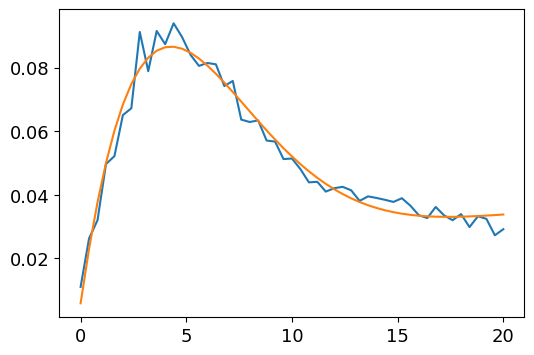



  freq: 0.038169767255136905 +/- 0.003251679408680298
 gamma: 0.21318713084286733 +/- 0.016849039164995302
   amp: 0.16815237943924663 +/- 0.02481185920445515
 phase: -10.381470842675528 +/- 1.7934934948116679
offset: 0.03614155240501615 +/- 0.0018010418214728507
pi_pulse time: 13.09937251274986 +/- 0.003251679408680298
J = 0.21: Angular freq (rad/µs): 0.2398277207959407


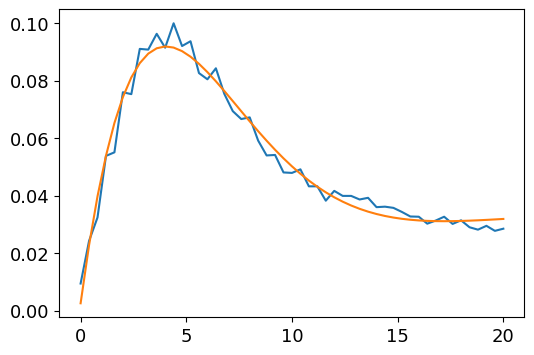



  freq: 0.037993080470355954 +/- 0.0029414670206934666
 gamma: 0.2285261671919071 +/- 0.015378342150743992
   amp: 0.20184905140655662 +/- 0.02643608339531108
 phase: -8.958810800861604 +/- 1.3770334161985183
offset: 0.03397490121945675 +/- 0.001643354397574234
pi_pulse time: 13.160291132226677 +/- 0.0029414670206934666
J = 0.22: Angular freq (rad/µs): 0.23871756498583221


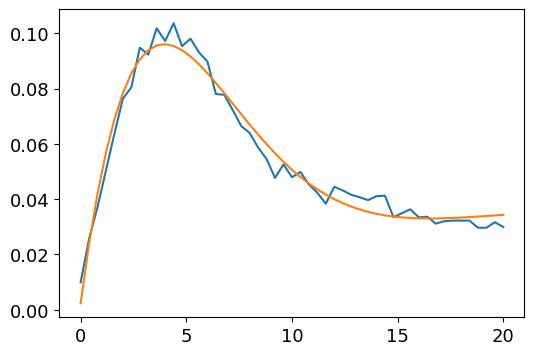



  freq: 0.039880050394301876 +/- 0.0029656718866309223
 gamma: 0.23224712567011158 +/- 0.01649127837861412
   amp: 0.20402955965809919 +/- 0.026524381341373
 phase: -9.566347067869657 +/- 1.4246833189834542
offset: 0.036267802345484615 +/- 0.001647911041933933
pi_pulse time: 12.537596995400005 +/- 0.0029656718866309223
J = 0.23: Angular freq (rad/µs): 0.250573746687059


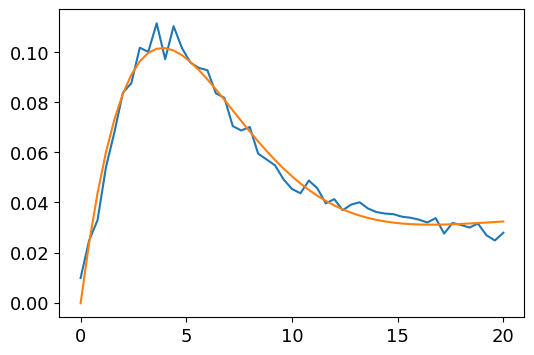



  freq: 0.03929420159482421 +/- 0.002952248288926438
 gamma: 0.2366055135291684 +/- 0.016327386924703046
   amp: 0.23295292209234522 +/- 0.03021490304118828
 phase: -8.568653845661782 +/- 1.301732825030335
offset: 0.034448465405427196 +/- 0.001781498665501065
pi_pulse time: 12.724523713591866 +/- 0.002952248288926438
J = 0.24: Angular freq (rad/µs): 0.24689275011795214


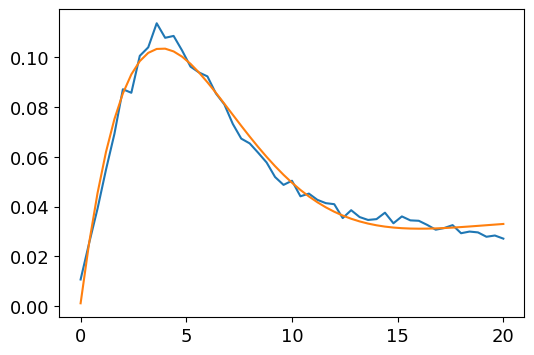



  freq: 0.04088485884410671 +/- 0.0023572990411192224
 gamma: 0.23330871469318917 +/- 0.014032099510536418
   amp: 0.2261061576668064 +/- 0.02369875971664338
 phase: -8.625136482448138 +/- 1.0753261106367442
offset: 0.035104959699039824 +/- 0.0014791500549451529
pi_pulse time: 12.229466216490845 +/- 0.0023572990411192224
J = 0.25: Angular freq (rad/µs): 0.25688714437540267


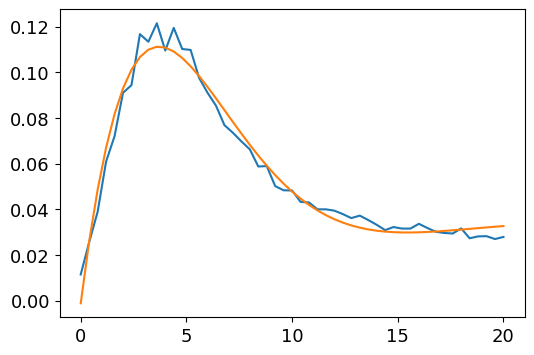



  freq: 0.042561548466869485 +/- 0.002496042617325932
 gamma: 0.23749381126335345 +/- 0.015917574133993726
   amp: 0.24681220439216153 +/- 0.027353760918971636
 phase: -8.311711761043286 +/- 1.1187055232021303
offset: 0.03457074687806179 +/- 0.0016906677706403043
pi_pulse time: 11.747692882678061 +/- 0.002496042617325932
J = 0.26: Angular freq (rad/µs): 0.2674220959778462


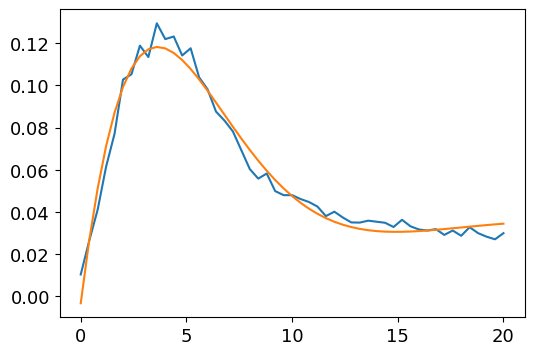



  freq: 0.0443401999843453 +/- 0.002364203429692308
 gamma: 0.23967927268063 +/- 0.01587779033095244
   amp: 0.2588746411350362 +/- 0.027002984406608126
 phase: -8.739450945485812 +/- 1.099016372982426
offset: 0.03611853757878223 +/- 0.0016862522421047525
pi_pulse time: 11.276448914901813 +/- 0.002364203429692308
J = 0.27: Angular freq (rad/µs): 0.2785976930590429


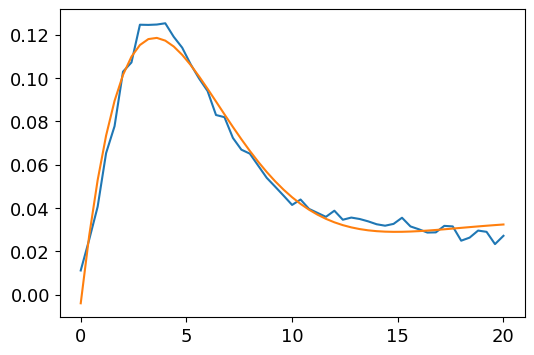



  freq: 0.0438881701696656 +/- 0.0024364667560217387
 gamma: 0.2516458106777686 +/- 0.016024627700734144
   amp: 0.27743364278325583 +/- 0.029110413572110687
 phase: -7.8274476525615215 +/- 1.0063065901315225
offset: 0.033812690281533775 +/- 0.0016397335125719057
pi_pulse time: 11.392591627016326 +/- 0.0024364667560217387
J = 0.28: Angular freq (rad/µs): 0.2757575059690403


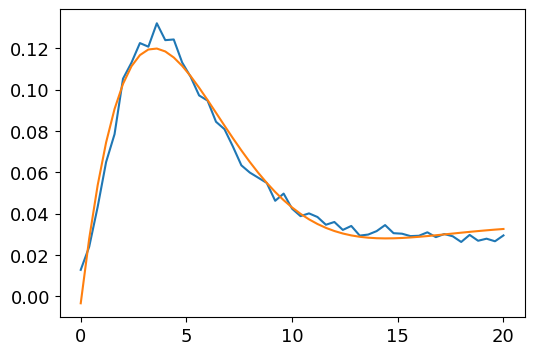



  freq: 0.045628650442778806 +/- 0.0021578411982288723
 gamma: 0.24639029691879646 +/- 0.01523543301447751
   amp: 0.2683145192554099 +/- 0.025444422185432625
 phase: -7.966906108628892 +/- 0.9587776471799073
offset: 0.033848500488359586 +/- 0.0015374323610000177
pi_pulse time: 10.95802736105534 +/- 0.0021578411982288723
J = 0.29: Angular freq (rad/µs): 0.2866932660485011


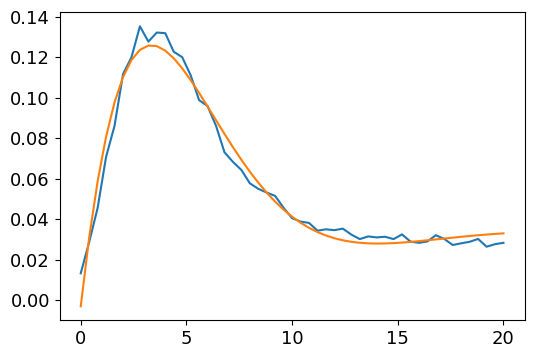



  freq: 0.04668523708343844 +/- 0.0021646425921257786
 gamma: 0.2561789883596793 +/- 0.01568078872556695
   amp: 0.2880288775601991 +/- 0.026896548913300244
 phase: -7.364924939036648 +/- 0.9084123251948715
offset: 0.03389258942569667 +/- 0.0015373660395582894
pi_pulse time: 10.710023794168 +/- 0.0021646425921257786
J = 0.3: Angular freq (rad/µs): 0.29333199570485596


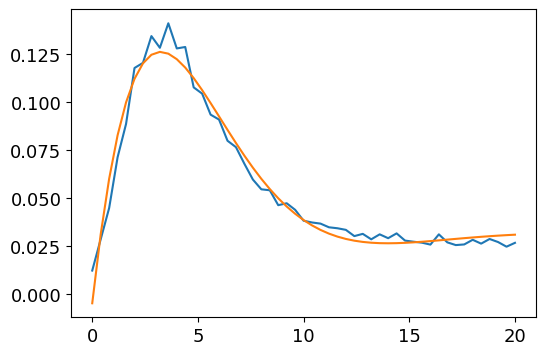



  freq: 0.04650806726059362 +/- 0.002530910741038445
 gamma: 0.26950244979300025 +/- 0.017873425444975055
   amp: 0.3067143525291326 +/- 0.03238231876294728
 phase: -6.8162127395194885 +/- 0.9536196565387552
offset: 0.03180795050933341 +/- 0.00167361097877369
pi_pulse time: 10.750823017400489 +/- 0.002530910741038445
J = 0.31: Angular freq (rad/µs): 0.2922188048770818


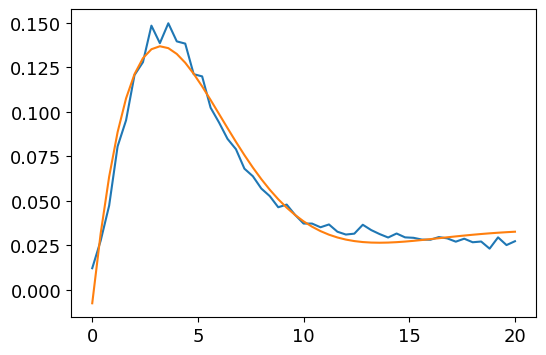



  freq: 0.048320209305341505 +/- 0.002326146105814059
 gamma: 0.26432408102440474 +/- 0.017386548526484746
   amp: 0.3228078043307511 +/- 0.03173431782180172
 phase: -7.249626775181906 +/- 0.9629849854547573
offset: 0.033212117322932284 +/- 0.0017629130329816873
pi_pulse time: 10.34763729685931 +/- 0.002326146105814059
J = 0.32: Angular freq (rad/µs): 0.3036048291471641


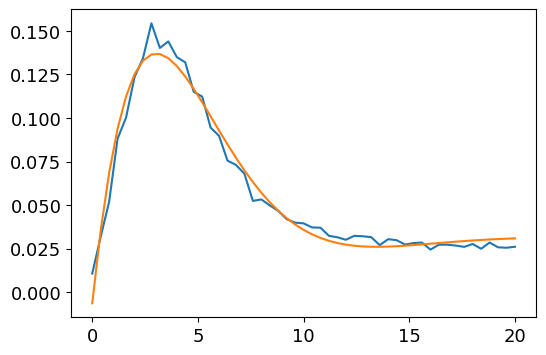



  freq: 0.04801006192043756 +/- 0.002524105462363621
 gamma: 0.2888031186872661 +/- 0.018049118397205795
   amp: 0.3514319729824924 +/- 0.035369831656928245
 phase: -6.150808126870065 +/- 0.8560530295718183
offset: 0.03125752404416099 +/- 0.001645240530286925
pi_pulse time: 10.414483547815491 +/- 0.002524105462363621
J = 0.33: Angular freq (rad/µs): 0.30165611565527545


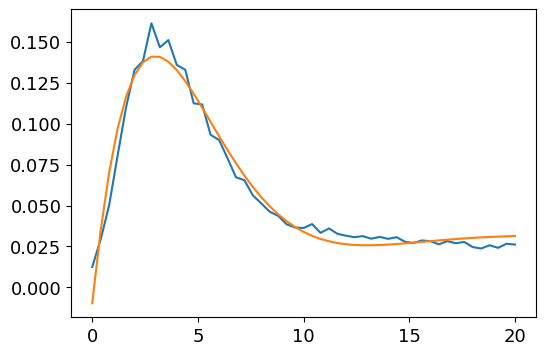



  freq: 0.049840859456263195 +/- 0.00278925532333568
 gamma: 0.29310588038427876 +/- 0.02049791245770412
   amp: 0.3596624186334 +/- 0.03925600596538886
 phase: -6.571276285293761 +/- 0.9785789243419974
offset: 0.03151208049942292 +/- 0.0018487272799961498
pi_pulse time: 10.031929735055323 +/- 0.00278925532333568
J = 0.34: Angular freq (rad/µs): 0.31315935583279564


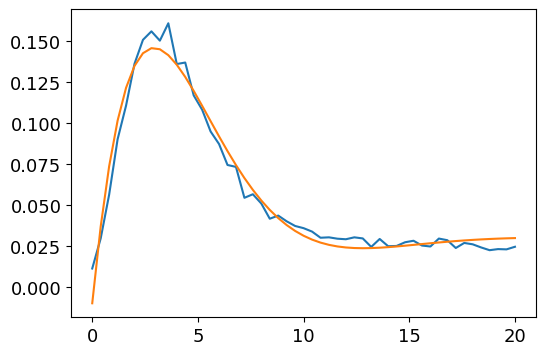



  freq: 0.05054825065332172 +/- 0.0025330444371551145
 gamma: 0.2959624770900607 +/- 0.019052518742342872
   amp: 0.37551193382916015 +/- 0.03720369736309789
 phase: -6.077032030935147 +/- 0.8783567959038893
offset: 0.03007524363180563 +/- 0.0017456658007110092
pi_pulse time: 9.891539144038472 +/- 0.0025330444371551145
J = 0.35000000000000003: Angular freq (rad/µs): 0.31760402580858194


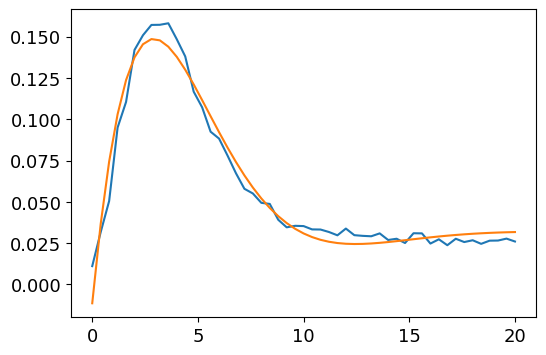



  freq: 0.052382160575531835 +/- 0.0025049387035968
 gamma: 0.2943629322512083 +/- 0.01946727011252153
   amp: 0.3702008916914574 +/- 0.03609218368670204
 phase: -6.66215613343807 +/- 0.9338625453433956
offset: 0.03153234938425619 +/- 0.0017809623907947838
pi_pulse time: 9.545234379537112 +/- 0.0025049387035968
J = 0.36: Angular freq (rad/µs): 0.3291268216865034


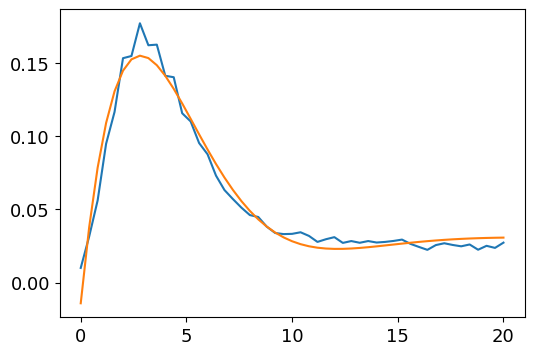



  freq: 0.053615295274040374 +/- 0.0026255910674412857
 gamma: 0.302647598964696 +/- 0.0206031315004818
   amp: 0.39376595432199635 +/- 0.039327988881926956
 phase: -6.491061346639489 +/- 0.9536317402844998
offset: 0.030458374237793198 +/- 0.0018911294929800809
pi_pulse time: 9.325697031870897 +/- 0.0026255910674412857
J = 0.37: Angular freq (rad/µs): 0.3368748355059456


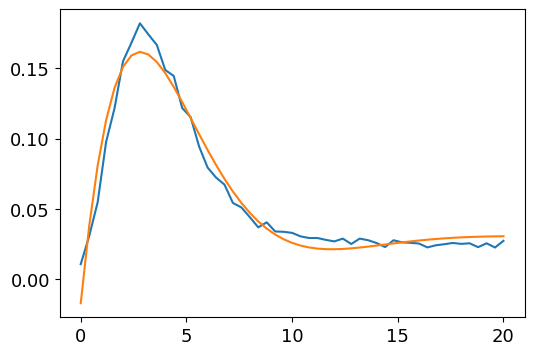



  freq: 0.05518894964144696 +/- 0.002583784943059984
 gamma: 0.2993603853350593 +/- 0.02099443278934842
   amp: 0.4037484253034943 +/- 0.039871670429617166
 phase: -6.704836536803942 +/- 1.0030813834033312
offset: 0.030157665023326514 +/- 0.002021981879815119
pi_pulse time: 9.059784671540468 +/- 0.002583784943059984
J = 0.38: Angular freq (rad/µs): 0.3467623975058136


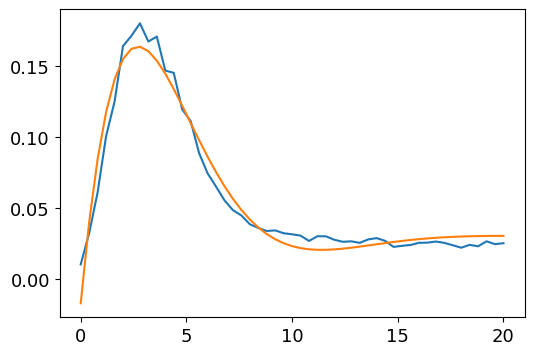



  freq: 0.05759968691873822 +/- 0.0026140580915181622
 gamma: 0.3081918757451038 +/- 0.021729120264952155
   amp: 0.40489329972397314 +/- 0.03929392123886517
 phase: -6.628981822747361 +/- 1.0134115583497822
offset: 0.02985387942921642 +/- 0.001984863208251997
pi_pulse time: 8.680602738438512 +/- 0.0026140580915181622
J = 0.39: Angular freq (rad/µs): 0.3619095065459602


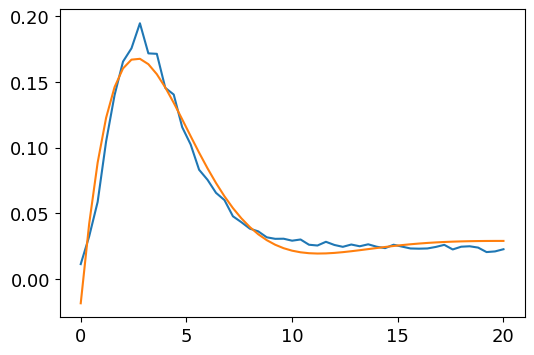



  freq: 0.05798788396543097 +/- 0.0027712196003350765
 gamma: 0.3176550467749957 +/- 0.022856973051550936
   amp: 0.42892827885233603 +/- 0.04315137591276497
 phase: -6.275236223598655 +/- 1.014184271295761
offset: 0.028324300312148762 +/- 0.0020795337221169883
pi_pulse time: 8.622490868921362 +/- 0.0027712196003350765
J = 0.4: Angular freq (rad/µs): 0.36434862052603056


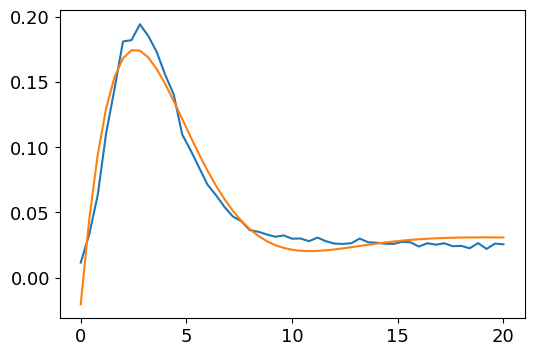



  freq: 0.06049643396206268 +/- 0.0028510110922599654
 gamma: 0.3250870461212346 +/- 0.023840163447053506
   amp: 0.4394195672489366 +/- 0.04406125147728983
 phase: -6.608497105595039 +/- 1.0530590518934146
offset: 0.03024826406699398 +/- 0.0021414441022984815
pi_pulse time: 8.264949969010571 +/- 0.0028510110922599654
J = 0.41000000000000003: Angular freq (rad/µs): 0.38011030500719234


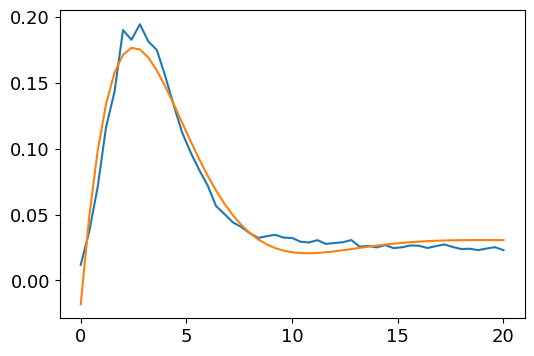



  freq: 0.060808643335886994 +/- 0.002907404187762212
 gamma: 0.33405244550527946 +/- 0.02420883303426611
   amp: 0.45092413576522106 +/- 0.045315920393391336
 phase: -6.127557253763167 +/- 1.0169807173992635
offset: 0.03005736298949143 +/- 0.002108105032057331
pi_pulse time: 8.222515296685112 +/- 0.002907404187762212
J = 0.42: Angular freq (rad/µs): 0.382071974357569


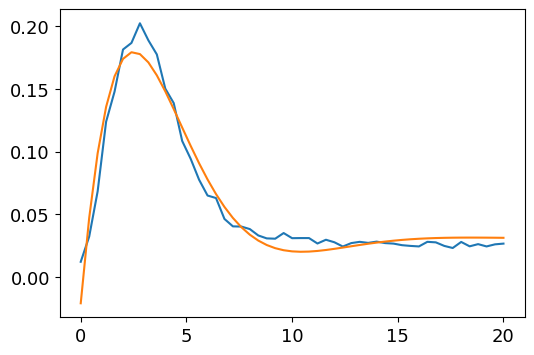



  freq: 0.06284991891066842 +/- 0.0029294983373908522
 gamma: 0.3325316044214288 +/- 0.02487546715863344
   amp: 0.4463487105314368 +/- 0.04476460182090237
 phase: -6.640963032722968 +/- 1.0834399412832942
offset: 0.03079826677713704 +/- 0.002186833978346257
pi_pulse time: 7.95545974706306 +/- 0.0029294983373908522
J = 0.43: Angular freq (rad/µs): 0.3948976870569402


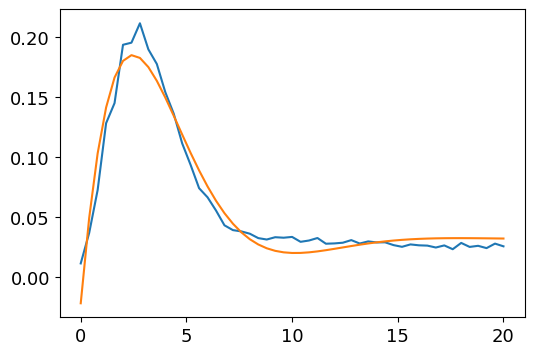



  freq: 0.06486824034100355 +/- 0.00300618968536939
 gamma: 0.33572408572957785 +/- 0.02591663796982577
   amp: 0.45289838123999565 +/- 0.045849052559989466
 phase: -6.77171621804435 +/- 1.133681307462516
offset: 0.03160930077667154 +/- 0.0022864800257000072
pi_pulse time: 7.707932223404978 +/- 0.00300618968536939
J = 0.44: Angular freq (rad/µs): 0.40757917461318766


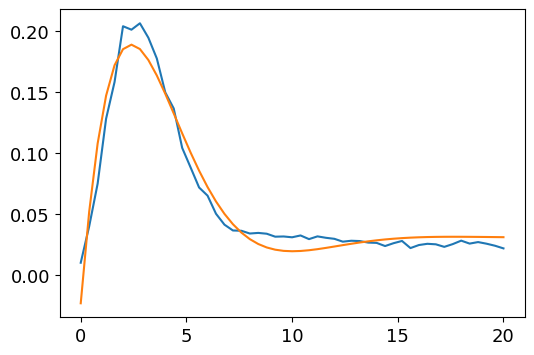



  freq: 0.06553605586683806 +/- 0.0031618592495175155
 gamma: 0.34842259157394895 +/- 0.02695912753397053
   amp: 0.4750563804410327 +/- 0.04910916704426723
 phase: -6.48605057788857 +/- 1.1126962668679397
offset: 0.03081773068748226 +/- 0.0023195676378375517
pi_pulse time: 7.629388027499613 +/- 0.0031618592495175155
J = 0.45: Angular freq (rad/µs): 0.4117751833130174


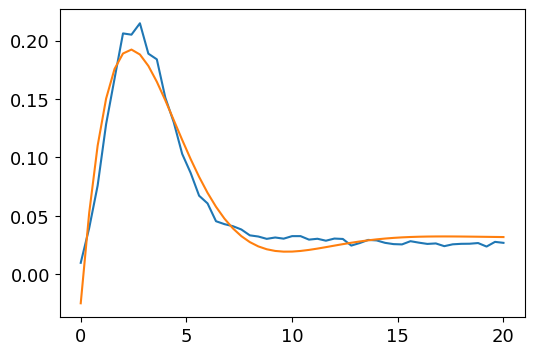



  freq: 0.06755796600088321 +/- 0.0031338365200089323
 gamma: 0.3491059893236392 +/- 0.027102866618193732
   amp: 0.4744370629307771 +/- 0.04798135391708743
 phase: -6.810351535714146 +/- 1.1404326951664543
offset: 0.03148434872873876 +/- 0.0023437946531224183
pi_pulse time: 7.401051713035045 +/- 0.0031338365200089323
J = 0.46: Angular freq (rad/µs): 0.4244792193596874


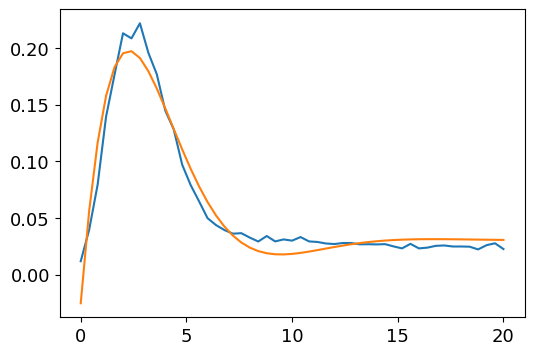



  freq: 0.06949281375877167 +/- 0.0033095503754558336
 gamma: 0.359810283454338 +/- 0.028834269233777205
   amp: 0.49211070829606535 +/- 0.05116028617133109
 phase: -6.495540504860261 +/- 1.1668871480737204
offset: 0.030373717705027406 +/- 0.00244969795872415
pi_pulse time: 7.1949885600493175 +/- 0.0033095503754558336
J = 0.47000000000000003: Angular freq (rad/µs): 0.43663622636368155


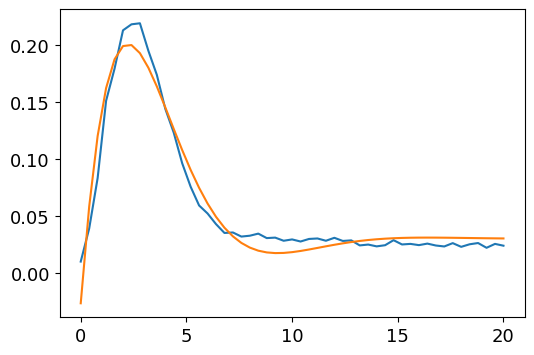



  freq: 0.07068529661602838 +/- 0.003228068186524816
 gamma: 0.36754316627292555 +/- 0.028089892161256666
   amp: 0.5028931930106222 +/- 0.0499308690109978
 phase: -6.464204299995326 +/- 1.107811839640997
offset: 0.030408338332270437 +/- 0.0023488009501800708
pi_pulse time: 7.073606873520872 +/- 0.003228068186524816
J = 0.48: Angular freq (rad/µs): 0.4441288171314604


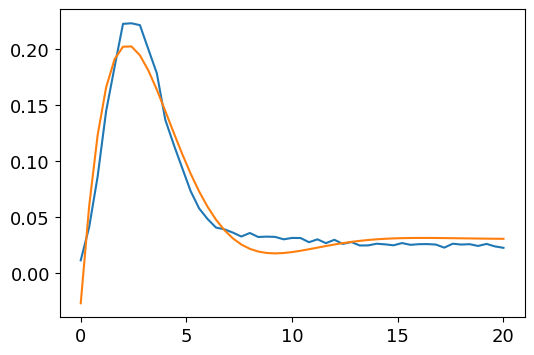



  freq: 0.07160689859641786 +/- 0.0035401911173911366
 gamma: 0.3723642282387877 +/- 0.030833392040748434
   amp: 0.5106450508922895 +/- 0.054845051507739634
 phase: -6.456534548325882 +/- 1.1990973221605183
offset: 0.03046172673466832 +/- 0.0025610435936601807
pi_pulse time: 6.982567459289635 +/- 0.0035401911173911366
J = 0.49: Angular freq (rad/µs): 0.44991941315371126


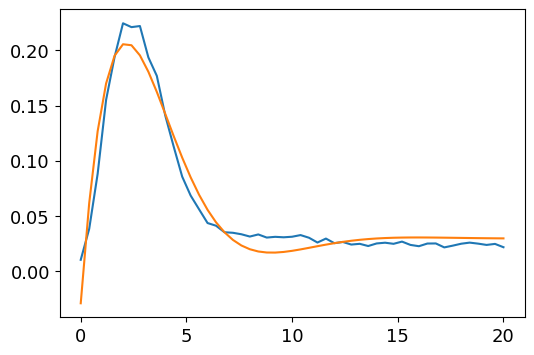



  freq: 0.0727597860592412 +/- 0.0035651036317102046
 gamma: 0.381770170223089 +/- 0.030922283591199647
   amp: 0.5255056887924636 +/- 0.055506572597674414
 phase: -6.41642828168484 +/- 1.1641148102172794
offset: 0.02949346050322986 +/- 0.0025265714338872335
pi_pulse time: 6.871927847518665 +/- 0.0035651036317102046
J = 0.5: Angular freq (rad/µs): 0.4571632187209544
J = 0.0: omega = nan rad/µs
J = 0.01: omega = nan rad/µs
J = 0.02: omega = nan rad/µs
J = 0.03: omega = nan rad/µs
J = 0.04: omega = nan rad/µs
J = 0.05: omega = 0.42034966530169576 rad/µs
J = 0.06: omega = nan rad/µs
J = 0.07: omega = 0.32259668113324874 rad/µs
J = 0.08: omega = 0.3319190694319292 rad/µs
J = 0.09: omega = 0.18665447952907066 rad/µs
J = 0.1: omega = 0.3043109841784799 rad/µs
J = 0.11: omega = 0.14788812348918975 rad/µs
J = 0.12: omega = 0.2302020134294212 rad/µs
J = 0.13: omega = 0.2617083470670554 rad/µs
J = 0.14: omega = 0.2508559660137898 rad/µs
J = 0.15: omega = 0.2456460326742257 rad/µs
J = 0.16: ome

In [ ]:
# Now call the function to process each J value and extract the angular frequency
probs_folder = os.path.join("sweep_J_data", "probs")
values_folder = os.path.join("sweep_J_data", "values")
probability_dataframes = {}
for J in J_list:
    prob_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")
    values_filename = os.path.join(values_folder, f"j={J:.3f}.pkl")

    # If both files already exist, load them and skip this iteration
    if os.path.exists(prob_filename) and os.path.exists(values_filename):
        with open(prob_filename, "rb") as f:
            df_prob = pickle.load(f)
        probability_dataframes[J] = df_prob
# probability_dataframes = 0
omega_dict = sweep_J_curve_fit(probability_dataframes)

# Print the results
for J, omega in omega_dict.items():
    print(f"J = {J}: omega = {omega} rad/µs")
J_vals = sorted(omega_dict.keys())
omegas = [omega_dict[J] for J in J_vals]


# Set initial guesses based on your expectations:
initial_guess_J0 = 0.1  # for example
initial_offset = 0.0  # for example
mask_rb = ~np.isnan(omegas)


# # Perform the curve fitting and plotting
# popt, pcov = curve_fit_and_plot(
#     np.array(J_vals)[mask_rb], np.array(omegas)[mask_rb], initial_guess_J0

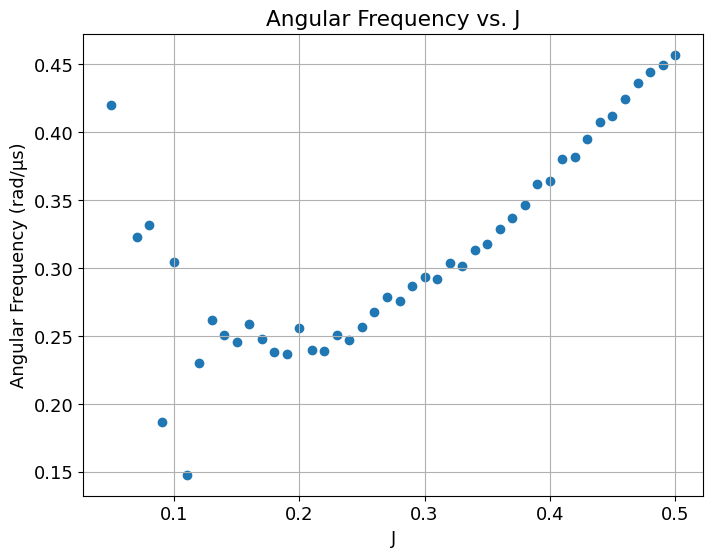

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(J_vals, omegas, marker="o")
plt.xlabel("J")
plt.ylabel("Angular Frequency (rad/µs)")
plt.title("Angular Frequency vs. J")
plt.grid(True)
plt.show()

<Figure size 960x720 with 0 Axes>

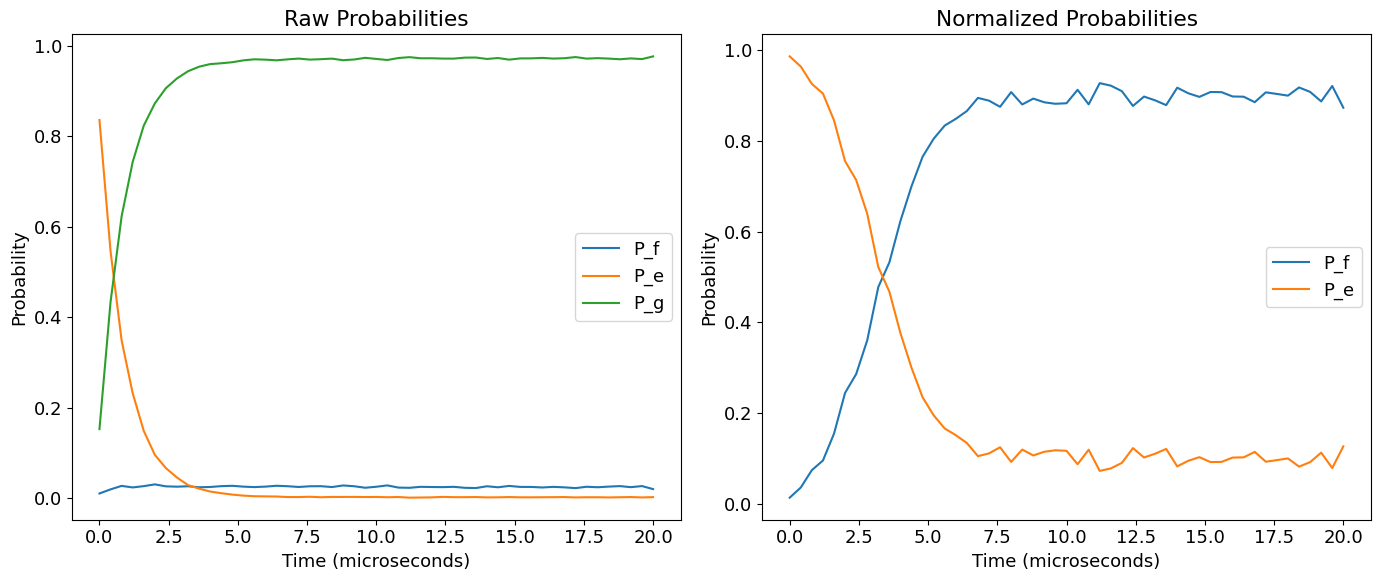

In [ ]:
J = 0

probs_folder = os.path.join("sweep_J_data", "probs")
pkl_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")

with open(pkl_filename, "rb") as f:
    probability_dataframes = pickle.load(f)  # This is your DataFrame for J=2

# Assuming probability_dataframes is the DataFrame loaded for J=2
# Extract the raw probabilities into an array (if needed)
measured_pop = np.array([
    probability_dataframes["P_g"],
    probability_dataframes["P_e"],
    probability_dataframes["P_f"]
])

# Compute normalization factor (using P_f and P_e)
normalization_val = probability_dataframes["P_f"] + probability_dataframes["P_e"]

# Create a new DataFrame with normalized probabilities
normalized_df = pd.DataFrame({
    "time": probability_dataframes["time"],
    "P_f": probability_dataframes["P_f"] / normalization_val,
    "P_e": probability_dataframes["P_e"] / normalization_val,
    "P_g": probability_dataframes["P_g"] / normalization_val,
})

# List of keys to plot
keys = ["P_f", "P_e", "P_g"]

# Create figure and two subplots
plt.figure(dpi=150)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot raw probabilities in the first subplot
for key in keys:
    sns.lineplot(data=probability_dataframes, x="time", y=key, ax=axes[0], label=key)

# Plot normalized probabilities in the second subplot (skip "P_g" if desired)
for key in keys:
    if key != "P_g":  # Plot only P_f and P_e for normalization if that’s your intention
        sns.lineplot(data=normalized_df, x="time", y=key, ax=axes[1], label=key)

# Set labels and titles for clarity
axes[0].set_xlabel("Time (microseconds)")
axes[0].set_ylabel("Probability")
axes[0].set_title("Raw Probabilities")
axes[0].legend()

axes[1].set_xlabel("Time (microseconds)")
axes[1].set_ylabel("Probability")
axes[1].set_title("Normalized Probabilities")
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()



<Figure size 960x720 with 0 Axes>

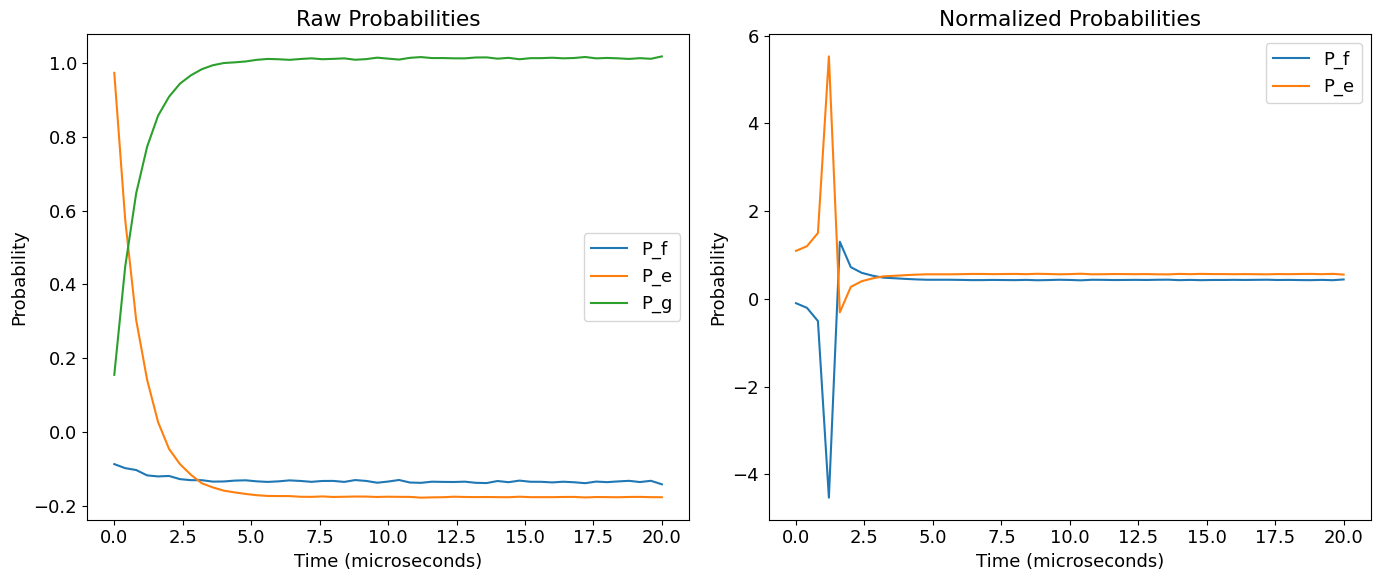

In [ ]:
scale_matrix = np.array([
    [0.96513333, 0.00563333, 0.02923333],
    [0.14921667, 0.8369,     0.01388333],
    [0.14105,    0.05938333, 0.79956667]
])
inv_matrix = np.linalg.inv(scale_matrix)
scaled_pop =np.matmul(inv_matrix,measured_pop )
scaled_df = pd.DataFrame({
    "time": probability_dataframes["time"],
    "P_f": scaled_pop[2],
    "P_e": scaled_pop[1],
    "P_g": scaled_pop[0],
})
# Compute normalization factor (using P_f and P_e)
normalization_val_scaled = scaled_pop[1]+scaled_pop[2]

# Create a new DataFrame with normalized probabilities
normalized_scaled_df = pd.DataFrame({
    "time": probability_dataframes["time"],
    "P_f": scaled_pop[2]/normalization_val_scaled,
    "P_e": scaled_pop[1]/normalization_val_scaled,
    "P_g": scaled_pop[0]/normalization_val_scaled,
})
# List of keys to plot
keys = ["P_f", "P_e", "P_g"]

# Create figure and two subplots
plt.figure(dpi=150)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot raw probabilities in the first subplot
for key in keys:
    sns.lineplot(data=scaled_df, x="time", y=key, ax=axes[0], label=key)

# Plot normalized probabilities in the second subplot (skip "P_g" if desired)
for key in keys:
    if key != "P_g":  # Plot only P_f and P_e for normalization if that’s your intention
        sns.lineplot(data=normalized_scaled_df, x="time", y=key, ax=axes[1], label=key)

# Set labels and titles for clarity
axes[0].set_xlabel("Time (microseconds)")
axes[0].set_ylabel("Probability")
axes[0].set_title("Raw Probabilities")
axes[0].legend()

axes[1].set_xlabel("Time (microseconds)")
axes[1].set_ylabel("Probability")
axes[1].set_title("Normalized Probabilities")
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [ ]:


# Define parameters
num_steps = 51
sweep_time = 20000  # in microseconds
J_start = 0        # starting J value
J_stop = 0.5       # ending J value
J_steps = 51       # number of J values

# Generate an array of J values
J_vals = np.linspace(J_start, J_stop, J_steps)

# Initialize a 2D array to store normalized P_f values
p_f = np.zeros((J_steps, num_steps))

# Loop over each J value, and calculate the normalized P_f
for i, J in enumerate(J_vals):
    # Access the DataFrame for the current J
    df = probability_dataframes[J]
    
    # Compute normalized P_f using P_f / (P_f + P_e)
    p_f[i] = df["P_f"] / (df["P_f"] + df["P_e"])

# Create the 2D plot
plt.figure(dpi=150)
# extent: [x_min, x_max, y_min, y_max] where time is on x and J on y.
plt.imshow(p_f, extent=[0, sweep_time / 1000, J_stop, J_start], aspect="auto")
plt.colorbar()
plt.ylabel("J (rads/microseconds)")
plt.xlabel("Time (microseconds)")
plt.title("P_f")
plt.show()


KeyError: 0.0

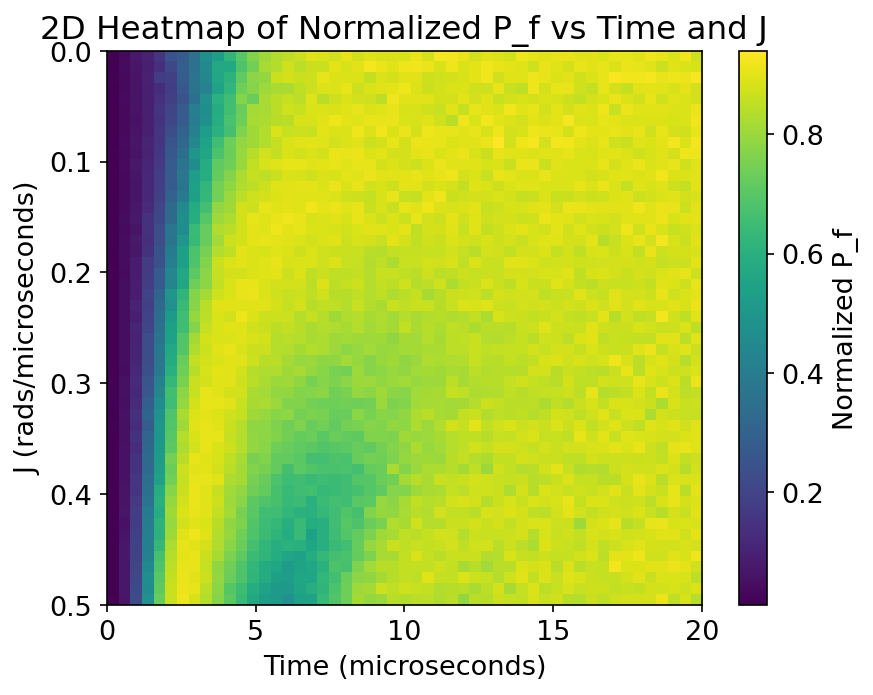

In [ ]:
# Initialize a dictionary to store the probability DataFrames for each J value
probability_dataframes = {}

# Loop over each J value and load the corresponding pickle file if it exists
for J in J_list:
    prob_filename = os.path.join(probs_folder, f"j={J:.3f}.pkl")
    values_filename = os.path.join(values_folder, f"j={J:.3f}.pkl")
    
    if os.path.exists(prob_filename) and os.path.exists(values_filename):
        with open(prob_filename, "rb") as f:
            df_prob = pickle.load(f)
        probability_dataframes[J] = df_prob
    else:
        print(f"Data for J = {J:.3f} not found. Skipping.")

# ---------------------------
# 2. Prepare Data for 2D Plotting
# ---------------------------

# Define parameters for the sweep
num_steps = 51      # number of time steps (should match what you used when saving the data)
sweep_time = 20000  # total sweep time in microseconds

# Initialize a 2D array to hold the normalized P_f values
p_f = np.zeros((J_steps, num_steps))

# For each J value, compute the normalized P_f as P_f / (P_f + P_e)
for i, J in enumerate(J_list):
    df = probability_dataframes.get(J)
    if df is not None:
        # Compute normalized P_f
        p_f[i] = df["P_f"] / (df["P_f"] + df["P_e"])
    else:
        # Fill with NaN if data is missing for a specific J
        p_f[i] = np.nan

# ---------------------------
# 3. Create the 2D Plot
# ---------------------------

plt.figure(dpi=150)
# The extent parameter maps the array indices to real data coordinates:
# [x_min, x_max, y_min, y_max]
plt.imshow(p_f, extent=[0, sweep_time/1000, J_stop, J_start], aspect="auto")
plt.colorbar(label="Normalized P_f")
plt.xlabel("Time (microseconds)")
plt.ylabel("J (rads/microseconds)")
plt.title("2D Heatmap of Normalized P_f vs Time and J")
plt.show()

In [ ]:
J_stop

1.0